## Convert data and load map

In [1]:
from collections import defaultdict
import json
import os
from tqdm.auto import tqdm

from text_clean import clean_text


def norm_text(s):
    return ' '.join(clean_text(s).strip().split())


data_dir = 'data/'
file_map = {
    "hotpot-train": "HotpotQA/hotpot_train_v1.1.json",
    "hotpot-dev": "HotpotQA/hotpot_dev_fullwiki_v1.json",
    "hotpot-test": "HotpotQA/hotpot_test_fullwiki_v1.json"
}

sp_titles = set()
for k, raw_file in file_map.items():
    with open(os.path.join(data_dir, raw_file)) as fin, open(os.path.join(data_dir, f"{k}.tsv"), 'w') as fout:
        samples = json.load(fin)
        for sample in tqdm(samples):
            q_id = sample['_id']
            question = norm_text(sample['question'])
            if 'test' in k:
                fout.write(f"{q_id}\t{question}\n")
                fout.flush()
            else:
                answer = norm_text(sample['answer'])
                sp_facts = defaultdict(list)
                for sp in sample['supporting_facts']:
                    title = norm_text(sp[0])
                    sp_facts[title].append(sp[1])
                    sp_titles.add(title)
                fout.write(f"{q_id}\t{question}\t{answer}\t{json.dumps(sp_facts, ensure_ascii=False)}\n")
                fout.flush()
print(f"#Title (supporting fact) in hotpot {len(sp_titles):,d}")


#Title (supporting fact) in hotpot 111,140


In [2]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers

hotpot_paragraphs = dict()
hotpot_title2id = dict()

index_name = 'enwiki-20171001-paragraph-3'
es = Elasticsearch(['10.60.0.59:9200'], timeout=30)
hotpot_query = {"query": {"term": {"for_hotpot": True}}}
hotpot_para_num = es.count(index=index_name, body=hotpot_query)['count']
for hit in tqdm(helpers.scan(es, query=hotpot_query, index=index_name), total=hotpot_para_num):
    para = hit['_source']
    para_id = para['para_id']
    title = para['title']
    if title in hotpot_title2id:
        print(f"Duplicate title: {title}")
    hotpot_title2id[title] = para_id
    hotpot_paragraphs[para_id] = {"title": title, "text": para['text'], "hyperlinks": para['hyperlinks']}
print(f"#Title in hotpot {len(hotpot_title2id):,d}")


#Title in hotpot 5,232,077


In [3]:
print(f'"Harry Diamond" in SP titles: {"Harry Diamond" in sp_titles}')
print(f"Total {len(sp_titles):,d} SPs, {len(sp_titles - set(hotpot_title2id.keys()))} titles of SP not found")

"Harry Diamond" in SP titles: False
Total 111,140 SPs, 0 titles of SP not found


In [4]:
with open('data/corpus/hotpot-paragraph.tsv') as f:
    for line in f:
        segs = line.strip().split('\t')
        pid, text, title, sentence_spans = segs
        if pid != 'id':
            if pid not in hotpot_paragraphs:
                hotpot_paragraphs[pid] = {"title": title, "text": text, "sentence_spans": eval(sentence_spans)}
            else:
                hotpot_paragraphs[pid]['sentence_spans'] = eval(sentence_spans)

## eval BM25 on the HotpotQA dev set

In [5]:
samples = []
with open(os.path.join(data_dir, "hotpot-dev.tsv")) as f:
    for line in f:
        q_id, question, answer, sp_facts = line.strip().split('\t')
        sp_facts = json.loads(sp_facts)
        samples.append((q_id, (question, answer, sp_facts)))
print(len(samples))

7405


In [114]:
%load_ext autoreload
%autoreload 2
from sparse_retriever import SparseRetriever

sparse_retriever = SparseRetriever('enwiki-20171001-paragraph-3.1', ['10.60.0.59:9200'], timeout=30)

In [117]:
result_size = 1000

all_ranks = []
sp2_ranks = []
accuracies_at_k = [0.] * result_size
recalls_at_k = [0.] * result_size
hits_at_k = [0.] * result_size

for qid, qas in tqdm(samples):
    question, answer, sp_facts = qas
    rank_positions = {t: result_size * 2 for t in sp_facts.keys()}
    
    offset = 0
    size = 1000
    
    query = {
        "query": {
            "bool": {
                "must": {
                    "multi_match": {
                      "query": question,
                      "fields": ["title^1.25", "title_unescaped^1.25", "text", "title.bigram^1.25", "title_unescaped.bigram^1.25", "text.bigram"]
                    }
                },
                "filter": [
                    {"term": {"for_hotpot": True}}
                ]
            }
        }
    }
    
    for hit in helpers.scan(es, query=query, index=index_name, scroll='1m', size=size, preserve_order=True):
        offset += 1
        para = hit['_source']
        if para['title'] in sp_facts:
            rank_positions[para['title']] = offset
        if all(p <= offset for p in rank_positions.values()) or offset >= result_size:
            break
    all_ranks.append(rank_positions)
    
    first_p = min(rank_positions.values())
    last_p = max(rank_positions.values())
    sp2_ranks.append(sum(rank_positions.values()) / len(rank_positions))
    for p in range(last_p - 1, result_size):
        accuracies_at_k[p] += 1.
    for p in range(first_p - 1, result_size):
        if p >= last_p - 1:
            recalls_at_k[p] += 1.
        else:
            recalls_at_k[p] += 0.5
        hits_at_k[p] += 1.

accuracies_at_k = [s / len(samples) for s in accuracies_at_k]
recalls_at_k = [s / len(samples) for s in recalls_at_k]
hits_at_k = [s / len(samples) for s in hits_at_k]

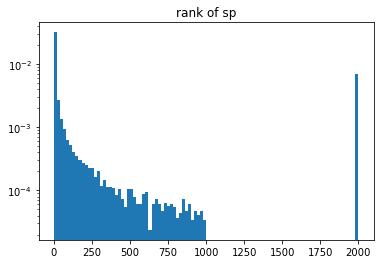

Max rank: 2000
Mean rank: 325.8775827143822


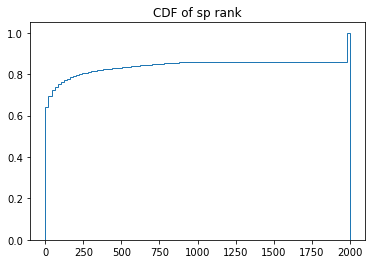

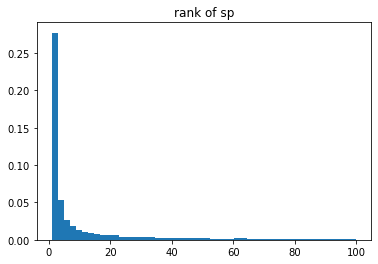

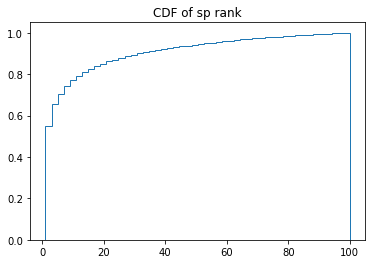

In [120]:
%matplotlib inline
import matplotlib.pyplot as plt

sp1_ranks = []
for rank_positions in all_ranks:
    sp1_ranks.extend(list(rank_positions.values()))


plt.title('rank of sp')
plt.hist(sp1_ranks, bins=100, density=True, log=True)
plt.show()
print(f"Max rank: {max(sp1_ranks)}")
print(f"Mean rank: {sum(sp1_ranks) / len(sp1_ranks)}")
plt.title('CDF of sp rank')
plt.hist(sp1_ranks, bins=100, cumulative=True, density=True, histtype='step')
plt.show()

plt.title('rank of sp')
plt.hist(sp1_ranks, bins=50, range=(1, 100), density=True)
plt.show()
plt.title('CDF of sp rank')
plt.hist(sp1_ranks, bins=50, range=(1, 100), cumulative=True, density=True, histtype='step')
plt.show()

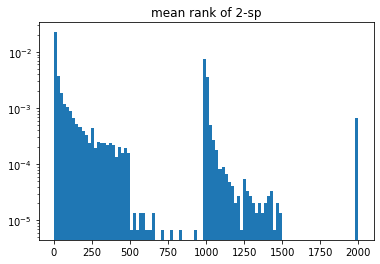

Max 2-sp average rank: 2000.0
Mean 2-sp average rank: 325.8775827143822


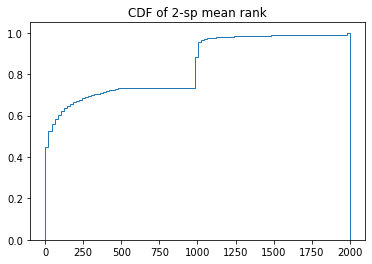

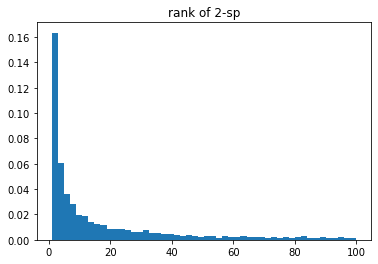

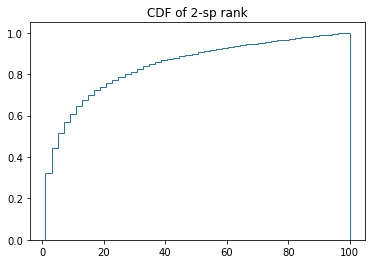

In [121]:
plt.title('mean rank of 2-sp')
plt.hist(sp2_ranks, bins=100, density=True, log=True)
plt.show()
print(f"Max 2-sp average rank: {max(sp2_ranks)}")
print(f"Mean 2-sp average rank: {sum(sp2_ranks) / len(sp2_ranks)}")

plt.title('CDF of 2-sp mean rank')
plt.hist(sp2_ranks, bins=100, cumulative=True, density=True, histtype='step')
plt.show()

plt.title('rank of 2-sp')
plt.hist(sp2_ranks, bins=50, range=(1, 100), density=True)
plt.show()
plt.title('CDF of 2-sp rank')
plt.hist(sp2_ranks, bins=50, range=(1, 100), cumulative=True, density=True, histtype='step')
plt.show()

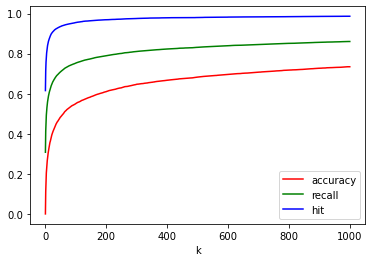

|   Metric |      1 |      2 |      5 |     10 |     20 |     50 |    100 |    200 |   1000 |
|----------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
| accuracy | 0.0000 | 0.1111 | 0.2273 | 0.3036 | 0.3816 | 0.4822 | 0.5500 | 0.6105 | 0.7346 |
|   recall | 0.3078 | 0.4130 | 0.5153 | 0.5799 | 0.6400 | 0.7086 | 0.7526 | 0.7898 | 0.8607 |
|      hit | 0.6157 | 0.7148 | 0.8034 | 0.8563 | 0.8983 | 0.9350 | 0.9552 | 0.9691 | 0.9868 |


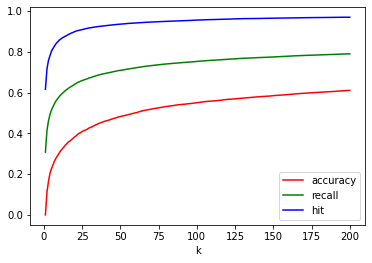

In [124]:
from prettytable import PrettyTable, MARKDOWN

x = [i + 1 for i in range(len(accuracies_at_k))]
plt.plot(x, accuracies_at_k, color='r', label="accuracy")
plt.plot(x, recalls_at_k, color='g', label="recall")
plt.plot(x, hits_at_k, color='b', label="hit")
plt.xlabel("k")
plt.legend(loc="best")
plt.show()

table = PrettyTable(field_names=["Metric", "1", "2", "5", "10", "20", "50", "100", "200", str(len(accuracies_at_k))], float_format='.4', align='r')
table.set_style(MARKDOWN)
table.add_rows(
    [
        ["accuracy", y1[0], y1[1], y1[4], y1[9], y1[19], y1[49], y1[99], y1[199], y1[-1]],
        ["recall", y2[0], y2[1], y2[4], y2[9], y2[19], y2[49], y2[99], y2[199], y2[-1]],
        ["hit", hits_at_k[0], hits_at_k[1], hits_at_k[4], hits_at_k[9], hits_at_k[19], hits_at_k[49], hits_at_k[99], hits_at_k[199], hits_at_k[-1]]
    ]
)
print(table)

plt.plot(x[:200], y1[:200], color='r', label="accuracy")
plt.plot(x[:200], y2[:200], color='g', label="recall")
plt.plot(x[:200], hits_at_k[:200], color='b', label="hit")
plt.xlabel("k")
plt.legend(loc="best")
plt.show()

enwiki-20171001-paragraph-3

|   Metric |      1 |      2 |      5 |     10 |     20 |     50 |    100 |    200 |  10000 |
|----------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
| accuracy | 0.0000 | 0.1151 | 0.2308 | 0.3078 | 0.3776 | 0.4710 | 0.5422 | 0.6022 | 0.8681 |
|   recall | 0.3085 | 0.4117 | 0.5157 | 0.5797 | 0.6342 | 0.6999 | 0.7467 | 0.7839 | 0.9329 |
|      hit | 0.6170 | 0.7083 | 0.8005 | 0.8516 | 0.8907 | 0.9287 | 0.9511 | 0.9656 | 0.9977 |

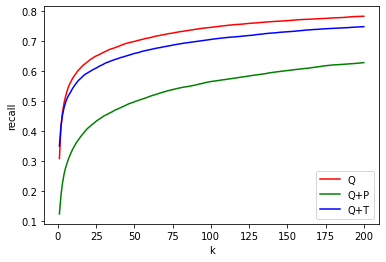

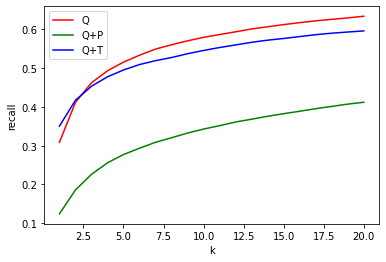

In [65]:
result_size = 200

num_q = 0
qt_recalls_at_k = [0.] * result_size
for qid, qas in tqdm(samples):
    question, answer, sp_facts = qas
    
    if len(sp_facts) < 2:
        print(f"less than 2 supporting facts: {qid}")
        continue
    
    sp_ids = [hotpot_title2id[t] for t in sp_facts.keys()]
    
    query = {
      "query": {
            "bool": {
                "must": {
                    # ' '.join(f"{question} {hotpot_paragraphs[sp_ids[0]]['title']} {hotpot_paragraphs[sp_ids[0]]['text']}".split()[:256])}
                    "match": {"text": f"{question} {hotpot_paragraphs[sp_ids[0]]['title']}"}
                },
                "must_not" : {
                    "ids" : {"values": [sp_ids[0]]}
                },
                "filter": {
                    "term": {"for_hotpot": True}
                }
            }
        },
        "size": result_size
    }
    for idx, hit in enumerate(es.search(query, index_name)['hits']['hits']):
        para = hit['_source']
        if para['para_id'] == sp_ids[1]:
            for p in range(idx, result_size):
                qt_recalls_at_k[p] += 1.
            break
    num_q += 1
    
    query = {
      "query": {
            "bool": {
                "must": {
                    # ' '.join(f"{question} {hotpot_paragraphs[sp_ids[1]]['title']} {hotpot_paragraphs[sp_ids[1]]['text']}".split()[:256])
                    "match": {"text": f"{question} {hotpot_paragraphs[sp_ids[1]]['title']}"}
                },
                "must_not" : {
                    "ids" : {"values": [sp_ids[1]]}
                },
                "filter": [
                    {"term": {"for_hotpot": True}}
                ]
            }
        },
        "size": result_size
    }
    for idx, hit in enumerate(es.search(query, index_name)['hits']['hits']):
        para = hit['_source']
        if para['para_id'] == sp_ids[0]:
            for p in range(idx, result_size):
                qt_recalls_at_k[p] += 1.
            break
    num_q += 1
qt_recalls_at_k = [x / num_q for x in qt_recalls_at_k]

q_recalls_at_k = [s / len(samples) for s in recalls_at_k]
plt.plot(x[:200], q_recalls_at_k[:200], color='r', label="Q")
plt.plot(x[:200], qp_recalls_at_k[:200], color='g', label="Q+P")
plt.plot(x[:200], qt_recalls_at_k[:200], color='b', label="Q+T")
plt.xlabel("k")
plt.ylabel("recall")
plt.legend(loc="best")
plt.show()

plt.plot(x[:20], q_recalls_at_k[:20], color='r', label="Q")
plt.plot(x[:20], qp_recalls_at_k[:20], color='g', label="Q+P")
plt.plot(x[:20], qt_recalls_at_k[:20], color='b', label="Q+T")
plt.xlabel("k")
plt.ylabel("recall")
plt.legend(loc="best")
plt.show()

In [170]:
def set_seed(seed):
    import random
    random.seed(seed)
    
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    import numpy as np
    np.random.seed(seed)
    
    import torch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(0)

In [233]:
# del qg1
# del qg2
torch.cuda.empty_cache()

In [169]:
%env CLASSPATH=corenlp/*
from drqa.reader import Predictor

import warnings 
warnings.filterwarnings("ignore")

# import os
# os.environ['CLASSPATH'] = 'corenlp/*'

qg1 = Predictor(model='ckpts/golden-retriever/hop1.mdl', tokenizer=None, embedding_file='data/glove.840B.300d.txt', num_workers=-1)
qg1.cuda()
qg2 = Predictor(model='ckpts/golden-retriever/hop2.mdl', tokenizer=None, embedding_file='data/glove.840B.300d.txt', num_workers=-1)
qg2.cuda()

env: CLASSPATH=corenlp/*


In [135]:
with open('SQuAD_hop2_input.json') as f:
#     print(type(json.load(f)['data']))
#     data = json.load(f)['data']
#     print(data[0])
    hop2_inputs = [x['paragraphs'][0]['context'] for x in json.load(f)['data']]

In [228]:
torch.backends.cudnn.benchmark = False
cached_queries = dict()

In [229]:
result_size = 100
n_retrieval = 2 * result_size

n_only_1hop = 0
hop1_queries = []
hop2_queries = []
hop2_tf_queries = []
hop1_at_k = [0.] * result_size
hop2_at_k = [0.] * result_size
hop2_tf_at_k = [0.] * result_size
sp_em_at_k = [0.] * (2 * result_size)
sp_recall_at_k = [0.] * (2 * result_size)
sp_hit_at_k = [0.] * (2 * result_size)

for (qid, qas), hop2_input in tqdm(zip(samples, hop2_inputs), total=len(samples)):
    question, answer, sp_facts = qas
    if len(sp_facts) < 2:
        print(f"less than 2 supporting facts: {qid}")
        continue
    
    sp_ids = set(hotpot_title2id[t] for t in sp_facts.keys())

    # hop 1
    hop1_sp_ranks = {sp_id: result_size for sp_id in sp_ids}
    if question not in cached_queries:
        cached_queries[question] = qg1.predict(question, question)[0][0]
    q1 = cached_queries[question]
    hop1_queries.append(q1)
    top_hop1_pids = []
    top5_hop1_paras = []
    for idx, hit in enumerate(sparse_retriever.search(q1, for_hotpot=True, n_rerank=result_size, n_retrieval=n_retrieval)):
        para = hit['_source']
        p_id = para['para_id']
        top_hop1_pids.append(p_id)
        if idx < 5:
            if p_id in hotpot_paragraphs and 'sentence_spans' in hotpot_paragraphs[p_id]:
                sentence_spans = hotpot_paragraphs[p_id]['sentence_spans']
                para_text = hotpot_paragraphs[p_id]['text'][sentence_spans[0][0]:sentence_spans[-1][-1]]
            else:
                para_text = '<UNK>'
            #para_text = para['text']
            top5_hop1_paras.append(f"<t> {para['title']} </t> {para_text}")
        if para['title'] in sp_facts.keys():
            hop1_sp_ranks[p_id] = min(idx, hop1_sp_ranks[p_id])
    for p in range(min(hop1_sp_ranks.values()), result_size):
        hop1_at_k[p] += 1.
    
    # check unrecalled sp id
    (easy_sp_id, easy_sp_rank), (hard_sp_id, hard_sp_rank) = sorted(hop1_sp_ranks.items(), key=lambda x: x[1])
    # remained_sp_ids = set([sp_id for sp_id, sp_rank in hop1_sp_ranks.items() if sp_rank >= result_size])
    
    # has recalled both @5?
    if hard_sp_rank < 5:
        for p in range(result_size):
            hop2_tf_at_k[p] += 1.
            hop2_at_k[p] += 1.
            if p >= hard_sp_rank:
                sp_em_at_k[p] += 1.
                sp_recall_at_k[p] += 1.
                sp_hit_at_k[p] += 1.
        n_only_1hop += 1
        hop2_queries.append('')
        hop2_tf_queries.append('')
        continue
    
    # teacher forcing hop 2
    hop2_tf_queries.append('tmp')
    if easy_sp_rank < result_size:
        #if easy_sp_id in top_hop1_pids[:5]:
        #    contexts = top5_hop1_paras
        #else:
        #    contexts = top5_hop1_paras[:4] + [f"<t> {hotpot_paragraphs[easy_sp_id]['title']} </t> {hotpot_paragraphs[easy_sp_id]['text']}"]
        contexts = [f"<t> {hotpot_paragraphs[easy_sp_id]['title']} </t> {hotpot_paragraphs[easy_sp_id]['text']}"]
        obs = ' '.join([question] + contexts)
        if obs not in cached_queries:
            cached_queries[obs] = qg2.predict(obs, question)[0][0]
        q2 = cached_queries[obs]
        for idx, hit in enumerate(sparse_retriever.search(q2, must_not={"ids": {"values": top_hop1_pids[:5]}}, for_hotpot=True, n_rerank=result_size, n_retrieval=n_retrieval)):
            if idx >= hard_sp_rank:
                break
            para = hit['_source']
            if para['para_id'] == hard_sp_id:
                hard_sp_rank = idx
                hop2_tf_queries[-1] = q2
                break
    else:
        assert hard_sp_rank >= result_size
        for (easy_sp_id, hard_sp_id) in [list(sp_ids), list(sp_ids)[::-1]]:
            #contexts = top5_hop1_paras[:4] + [f"<t> {hotpot_paragraphs[easy_sp_id]['title']} </t> {hotpot_paragraphs[easy_sp_id]['text']}"]
            contexts = [f"<t> {hotpot_paragraphs[easy_sp_id]['title']} </t> {hotpot_paragraphs[easy_sp_id]['text']}"]
            obs = ' '.join([question] + contexts)
            if obs not in cached_queries:
                cached_queries[obs] = qg2.predict(obs, question)[0][0]
            q2 = cached_queries[obs]
            for idx, hit in enumerate(sparse_retriever.search(q2, must_not={"ids": {"values": top_hop1_pids[:5]}}, for_hotpot=True, n_rerank=result_size, n_retrieval=n_retrieval)):
                if idx >= hard_sp_rank:
                    break
                para = hit['_source']
                if para['para_id'] == hard_sp_id:
                    hard_sp_rank = idx
                    hop2_tf_queries[-1] = q2
                    break
            if hard_sp_rank == 0:
                break
    if hop2_tf_queries[-1] == 'tmp':
        hop2_tf_queries[-1] = q2
    for p in range(hard_sp_rank, result_size):
            hop2_tf_at_k[p] += 1.
    
    # hop 2
    hop2_sp_ranks = {sp_id: result_size for sp_id in sp_ids}
    obs = ' '.join([question] + top5_hop1_paras)  # hop2_input
    if obs not in cached_queries:
        cached_queries[obs] = qg2.predict(obs, question)[0][0]
    q2 = cached_queries[obs]
    hop2_queries.append(q2)
#     print(q1, '|||', q2)
#     print(hop2_input)
#     print(obs, '\n')
    top_hop2_pids = []
    for idx, hit in enumerate(sparse_retriever.search(q2, must_not={"ids": {"values": top_hop1_pids[:5]}}, for_hotpot=True, n_rerank=result_size, n_retrieval=n_retrieval)):
        para = hit['_source']
        p_id = para['para_id']
        top_hop2_pids.append(p_id)
        if p_id in sp_ids:
            hop2_sp_ranks[p_id] = min(idx, hop2_sp_ranks[p_id])
    for p in range(min(hop2_sp_ranks.values()), result_size):
        hop2_at_k[p] += 1.
    
    # eval both
    sp_ranks = {sp_id: min(hop1_sp_ranks[sp_id], hop2_sp_ranks[sp_id]) for sp_id in sp_ids}
    for p in range(min(sp_ranks.values()), result_size):
        sp_hit_at_k[2 * (p + 1) - 1] += 1.
        sp_recall_at_k[2 * (p + 1) - 1] += 0.5
        if 2 * (p + 1) < 2 * result_size:
            sp_hit_at_k[2 * (p + 1)] += 1.
            sp_recall_at_k[2 * (p + 1)] += 0.5
        if p >= max(sp_ranks.values()):
            sp_recall_at_k[2 * (p + 1) - 1] += 0.5
            sp_em_at_k[2 * (p + 1) - 1] += 1
            if 2 * (p + 1) < 2 * result_size:
                sp_recall_at_k[2 * (p + 1)] += 0.5
                sp_em_at_k[2 * (p + 1)] += 1.

hop1_at_k = [x / len(samples) for x in hop1_at_k]
hop2_at_k = [x / len(samples) for x in hop2_at_k]
hop2_tf_at_k = [x / len(samples) for x in hop2_tf_at_k]
sp_em_at_k = [x / len(samples) for x in sp_em_at_k]
sp_recall_at_k = [x / len(samples) for x in sp_recall_at_k]
sp_hit_at_k = [x / len(samples) for x in sp_hit_at_k]

In [231]:
n_only_1hop

451

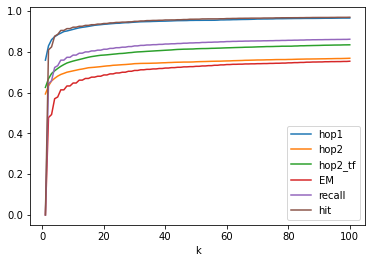

|  Metric |   1    |   2    |   5    |   10   |   20   |   50   |  100   |
|---------|--------|--------|--------|--------|--------|--------|--------|
|   hop1  | 0.7591 | 0.8290 | 0.8839 | 0.9099 | 0.9348 | 0.9544 | 0.9656 |
|   hop2  | 0.5934 | 0.6328 | 0.6808 | 0.7065 | 0.7291 | 0.7511 | 0.7683 |
| hop2_tf | 0.6255 | 0.6679 | 0.7183 | 0.7545 | 0.7839 | 0.8149 | 0.8343 |
|    EM   | 0.0000 | 0.4777 | 0.5785 | 0.6469 | 0.6864 | 0.7288 | 0.7538 |
|  recall | 0.0000 | 0.6436 | 0.7319 | 0.7838 | 0.8126 | 0.8444 | 0.8616 |
|   hit   | 0.0000 | 0.8095 | 0.8853 | 0.9207 | 0.9388 | 0.9600 | 0.9695 |


In [232]:
x = [i + 1 for i in range(len(hop1_at_k))]
plt.plot(x, hop1_at_k, label="hop1")
plt.plot(x, hop2_at_k, label="hop2")
plt.plot(x, hop2_tf_at_k, label="hop2_tf")
plt.plot(x, sp_em_at_k[:len(x)], label="EM")
plt.plot(x, sp_recall_at_k[:len(x)], label="recall")
plt.plot(x, sp_hit_at_k[:len(x)], label="hit")
plt.xlabel("k")
plt.legend(loc="best")
plt.show()

table = PrettyTable(field_names=["Metric", "1", "2", "5", "10", "20", "50", "100"], float_format='.4', align='c')
table.set_style(MARKDOWN)
table.add_rows([
    ["hop1", hop1_at_k[0], hop1_at_k[1], hop1_at_k[4], hop1_at_k[9], hop1_at_k[19], hop1_at_k[49], hop1_at_k[99]],
    ["hop2", hop2_at_k[0], hop2_at_k[1], hop2_at_k[4], hop2_at_k[9], hop2_at_k[19], hop2_at_k[49], hop2_at_k[99]],
    ["hop2_tf", hop2_tf_at_k[0], hop2_tf_at_k[1], hop2_tf_at_k[4], hop2_tf_at_k[9], hop2_tf_at_k[19], hop2_tf_at_k[49], hop2_tf_at_k[99]],
    ["EM", sp_em_at_k[0], sp_em_at_k[1], sp_em_at_k[4], sp_em_at_k[9], sp_em_at_k[19], sp_em_at_k[49], sp_em_at_k[99]],
    ["recall", sp_recall_at_k[0], sp_recall_at_k[1], sp_recall_at_k[4], sp_recall_at_k[9], sp_recall_at_k[19], sp_recall_at_k[49], sp_recall_at_k[99]],
    ["hit", sp_hit_at_k[0], sp_hit_at_k[1], sp_hit_at_k[4], sp_hit_at_k[9], sp_hit_at_k[19], sp_hit_at_k[49], sp_hit_at_k[99]]
])
print(table)

|  Metric  |   1    |   2    |   5    |   10   |   20   |   50   |  100   |
|----------|--------|--------|--------|--------|--------|--------|--------|
|   hop1   | 0.7591 | 0.8290 | 0.8839 | 0.9099 | 0.9348 | 0.9544 | 0.9656 |
|   hop2   | 0.5934 | 0.6328 | 0.6808 | 0.7065 | 0.7291 | 0.7511 | 0.7683 |
| hop2_tf  | 0.6101 | 0.6502 | 0.6963 | 0.7315 | 0.7615 | 0.7907 | 0.8105 |
| hop2_tf1 | 0.6255 | 0.6679 | 0.7183 | 0.7545 | 0.7839 | 0.8149 | 0.8343 |
|    EM    | 0.0000 | 0.4777 | 0.5785 | 0.6469 | 0.6864 | 0.7288 | 0.7538 |
|  recall  | 0.0000 | 0.6436 | 0.7319 | 0.7838 | 0.8126 | 0.8444 | 0.8616 |
|   hit    | 0.0000 | 0.8095 | 0.8853 | 0.9207 | 0.9388 | 0.9600 | 0.9695 |

- hop2 with new para text

|  Metric |   1    |   2    |   5    |   10   |   20   |   50   |  100   |
|---------|--------|--------|--------|--------|--------|--------|--------|
|   hop1  | 0.7591 | 0.8290 | 0.8839 | 0.9099 | 0.9348 | 0.9544 | 0.9656 |
|   hop2  | 0.5851 | 0.6248 | 0.6727 | 0.6986 | 0.7221 | 0.7430 | 0.7604 |
| hop2_tf | 0.6255 | 0.6679 | 0.7183 | 0.7545 | 0.7839 | 0.8149 | 0.8343 |
|    EM   | 0.0000 | 0.4731 | 0.5722 | 0.6404 | 0.6812 | 0.7253 | 0.7492 |
|  recall | 0.0000 | 0.6394 | 0.7280 | 0.7797 | 0.8091 | 0.8421 | 0.8593 |
|   hit   | 0.0000 | 0.8058 | 0.8837 | 0.9190 | 0.9371 | 0.9589 | 0.9693 |

## eval DPR-FlatIP on the HotpotQA dev set

In [20]:
%env CUDA_VISIBLE_DEVICES=2,3

env: CUDA_VISIBLE_DEVICES=2,3


In [189]:
import faiss
faiss.omp_set_num_threads(16)

In [21]:
from argparse import Namespace
# import logging
import os

import torch

# logger = logging.getLogger()
# logger.setLevel(logging.WARNING)

os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"
args = Namespace(**{
    "pretrained_model_cfg": None,
    "encoder_model_type": None,
    "pretrained_file": None,
    "model_file": "ckpts/dpr/retriever/multiset/bert-base-encoder.cp",
    "projection_dim": 0,
    "sequence_length": 256,
    "do_lower_case": False,
    "no_cuda": False,
    "local_rank": -1,
    "fp16": False,
    "fp16_opt_level": "O1",
    "qa_file": "",
    "ctx_file": "data/hotpot-paragraph.tsv",
    "encoded_ctx_file": "data/hotpot-paragraph_*.pkl",
    "batch_size": 128,
    "n_docs": 200,
    "index_buffer": 50000,
    "hnsw_index": False,
    "save_or_load_index": "",
    "validation_workers": 16,
    "match": "string",
    "out_file": ""
})
args.device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
args.n_gpu = torch.cuda.device_count()

load the checkpoint file

In [22]:
from dpr.models import init_biencoder_components
from dpr.options import set_encoder_params_from_state
from dpr.utils.model_utils import setup_for_distributed_mode, get_model_obj, load_states_from_checkpoint
from dpr.indexer.faiss_indexers import DenseIndexer, DenseHNSWFlatIndexer, DenseFlatIndexer

ckpt_file = "ckpts/dpr/retriever/multiset/bert-base-encoder.cp"
saved_state = load_states_from_checkpoint(ckpt_file)
set_encoder_params_from_state(saved_state.encoder_params, args)

Overriding args parameter value from checkpoint state. Param = do_lower_case, value = True
Overriding args parameter value from checkpoint state. Param = pretrained_model_cfg, value = bert-base-uncased
Overriding args parameter value from checkpoint state. Param = encoder_model_type, value = hf_bert
Overriding args parameter value from checkpoint state. Param = sequence_length, value = 256


Namespace(batch_size=128, ctx_file='data/hotpot-paragraph.tsv', device=device(type='cuda'), do_lower_case=True, encoded_ctx_file='data/hotpot-paragraph_*.pkl', encoder_model_type='hf_bert', fp16=False, fp16_opt_level='O1', hnsw_index=False, index_buffer=50000, local_rank=-1, match='string', model_file='ckpts/dpr/retriever/multiset/bert-base-encoder.cp', n_docs=200, n_gpu=2, no_cuda=False, out_file='', pretrained_file=None, pretrained_model_cfg='bert-base-uncased', projection_dim=0, qa_file='', save_or_load_index='', sequence_length=256, validation_workers=16)

initialize the question encoder

In [23]:
tensorizer, encoder, _ = init_biencoder_components(saved_state.encoder_params['encoder_model_type'],
                                                   args, inference_only=True)
encoder = encoder.question_model
encoder, _ = setup_for_distributed_mode(encoder, None, args.device, args.n_gpu, args.local_rank, args.fp16)
encoder.eval()

DataParallel(
  (module): HFBertEncoder(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [24]:
model_to_load = get_model_obj(encoder)
prefix_len = len('question_model.')
question_encoder_state = {key[prefix_len:]: value
                          for (key, value) in saved_state.model_dict.items() if key.startswith('question_model.')}
model_to_load.load_state_dict(question_encoder_state)
vector_size = model_to_load.get_out_size()
print(f'Encoder vector_size={vector_size}')

Encoder vector_size=768


load the index into the memory

In [25]:
from dense_retriever import DenseRetriever

index_file_prefix = 'data/hotpot-paragraph'
index_buffer = 50000
batch_size = 128
index = DenseFlatIndexer(vector_size, index_buffer)
retriever = DenseRetriever(encoder, batch_size, tensorizer, index)
retriever.index.deserialize_from(index_file_prefix)

Loading index from data/hotpot-paragraph
Loaded index of type <class 'faiss.swigfaiss.IndexFlat'> and size 5232077


get questions & supporting facts

In [190]:
question_list = []
sp_facts_list = []
for sample in samples:
    question_list.append(sample[1][0])
    sp_facts_list.append([hotpot_title2id[title] for title in sample[1][-1].keys()])

encode questions to vectors

In [191]:
questions_tensor = retriever.generate_query_vectors(question_list)

100%|██████████| 58/58 [01:54<00:00,  1.97s/it]
Total encoded queries tensor torch.Size([7405, 768])


get top k paragraphs

In [192]:
%%time
n_docs = 200
top_ids_and_scores = retriever.get_top_docs(questions_tensor.numpy(), n_docs)

index search time: 190.606425 sec.


CPU times: user 43min 7s, sys: 7min 30s, total: 50min 38s
Wall time: 3min 10s


In [193]:
result_size = n_docs
dpr_all_ranks = []
dpr_sp2_ranks = []
dpr_accuracies_at_k = [0.] * result_size
dpr_recalls_at_k = [0.] * result_size
drp_hits_at_k = [0.] * result_size

for p_ids_and_scores, sp_facts in zip(top_ids_and_scores, sp_facts_list):
    rank_positions = {t: result_size * 2 for t in sp_facts}
    for idx, (p_id, score) in enumerate(zip(*p_ids_and_scores)):
        if p_id in rank_positions:
            rank_positions[p_id] = idx + 1
    dpr_all_ranks.append(rank_positions)
    
    first_p = min(rank_positions.values())
    last_p = max(rank_positions.values())
    dpr_sp2_ranks.append(sum(rank_positions.values()) / len(rank_positions))
    for p in range(last_p - 1, result_size):
        dpr_accuracies_at_k[p] += 1.
    for p in range(first_p - 1, result_size):
        if p >= last_p - 1:
            dpr_recalls_at_k[p] += 1.
        else:
            dpr_recalls_at_k[p] += 0.5
        drp_hits_at_k[p] += 1.
drp_hits_at_k = [x / len(samples) for x in drp_hits_at_k]

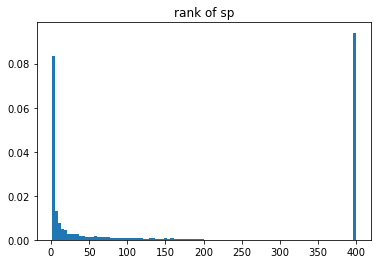

Max rank: 400
Mean rank: 165.65415259959488


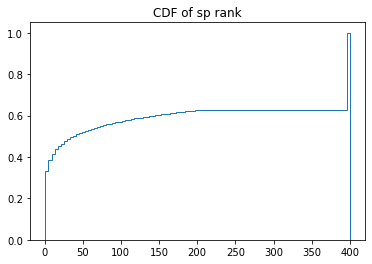

In [194]:
sp1_ranks = []
for rank_positions in dpr_all_ranks:
    sp1_ranks.extend(list(rank_positions.values()))

plt.title('rank of sp')
plt.hist(sp1_ranks, bins=100, density=True)
plt.show()
print(f"Max rank: {max(sp1_ranks)}")
print(f"Mean rank: {sum(sp1_ranks) / len(sp1_ranks)}")
plt.title('CDF of sp rank')
plt.hist(sp1_ranks, bins=100, cumulative=True, density=True, histtype='step')
plt.show()

# plt.title('rank of sp')
# plt.hist(sp1_ranks, bins=50, range=(1, result_size), density=True)
# plt.show()
# plt.title('CDF of sp rank')
# plt.hist(sp1_ranks, bins=50, range=(1, result_size), cumulative=True, density=True, histtype='step')
# plt.show()

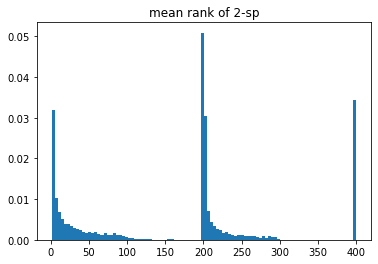

Max 2-sp average rank: 400.0
Mean 2-sp average rank: 165.65415259959488


In [195]:
plt.title('mean rank of 2-sp')
plt.hist(dpr_sp2_ranks, bins=100, density=True)
plt.show()
print(f"Max 2-sp average rank: {max(dpr_sp2_ranks)}")
print(f"Mean 2-sp average rank: {sum(dpr_sp2_ranks) / len(dpr_sp2_ranks)}")

plt.title('CDF of 2-sp mean rank')
plt.hist(dpr_sp2_ranks, bins=100, cumulative=True, density=True, histtype='step')
plt.show()

In [197]:
drp_hits_at_k = [x / len(samples) for x in drp_hits_at_k]

In [199]:
x = [i + 1 for i in range(result_size)]
y1 = [s / len(samples) for s in dpr_accuracies_at_k]
y2 = [s / len(samples) for s in dpr_recalls_at_k]
plt.plot(x, y1, color='r', label="accuracy")
plt.plot(x, y2, color='g', label="recall")
plt.plot(x, drp_hits_at_k, color='b', label="hit")
plt.xlabel("k")
plt.legend(loc="best")
plt.show()
table = PrettyTable(field_names=["Metric", "10", "20", "100", "200"], float_format='.4', align='r')
table.set_style(MARKDOWN)
table.add_rows(
    [
        ["accuracy", y1[9], y1[19], y1[99], y1[199]],
        ["recall", y2[9], y2[19], y2[99], y2[199]],
        ["hit", drp_hits_at_k[9], drp_hits_at_k[19], drp_hits_at_k[99], drp_hits_at_k[199]]
    ]
)
print(table)

|   Metric |     10 |     20 |    100 |    200 |
|----------|--------|--------|--------|--------|
| accuracy | 0.1418 | 0.1883 | 0.3192 | 0.3861 |
|   recall | 0.4037 | 0.4530 | 0.5708 | 0.6248 |
|      hit | 0.6656 | 0.7178 | 0.8223 | 0.8635 |


In [70]:
%%time
qps = []
sp_paras = []
for sample in samples:
    question, answer, sp_facts = sample[1]
    sp_ids = [hotpot_title2id[t] for t in sp_facts.keys()]
    
    qps.append(f"{question} {hotpot_paragraphs[sp_ids[0]]['title']} {hotpot_paragraphs[sp_ids[0]]['text']}")
    sp_paras.append(sp_ids[1])
    
    qps.append(f"{question} {hotpot_paragraphs[sp_ids[1]]['title']} {hotpot_paragraphs[sp_ids[1]]['text']}")
    sp_paras.append(sp_ids[0])

questions_tensor = retriever.generate_query_vectors(qps)
n_docs = 200
top_ids_and_scores = retriever.get_top_docs(questions_tensor.numpy(), n_docs)

result_size = n_docs
dpr_qp_ranks = []
dpr_qp_recalls_at_k = [0.] * result_size

for p_ids_and_scores, sp_id in zip(top_ids_and_scores, sp_paras):
    for idx, (p_id, score) in enumerate(zip(*p_ids_and_scores)):
        if p_id == sp_id:
            dpr_qp_ranks.append(idx + 1)
            for p in range(idx, result_size):
                dpr_qp_recalls_at_k[p] += 1.
dpr_qp_recalls_at_k = [x / len(qps) for x in dpr_qp_recalls_at_k]

100%|██████████| 116/116 [04:16<00:00,  2.21s/it]


In [128]:
%%time
qts = []
sp_paras = []
for sample in samples:
    question, answer, sp_facts = sample[1]
    sp_ids = [hotpot_title2id[t] for t in sp_facts.keys()]
    
    qts.append(f"{question} {hotpot_paragraphs[sp_ids[0]]['title']}")
    sp_paras.append(sp_ids[1])
    
    qts.append(f"{question} {hotpot_paragraphs[sp_ids[1]]['title']}")
    sp_paras.append(sp_ids[0])

questions_tensor = retriever.generate_query_vectors(qts)
n_docs = 200
top_ids_and_scores = retriever.get_top_docs(questions_tensor.numpy(), n_docs)

result_size = n_docs
dpr_qt_ranks = []
dpr_qt_recalls_at_k = [0.] * result_size

for p_ids_and_scores, sp_id in zip(top_ids_and_scores, sp_paras):
    for idx, (p_id, score) in enumerate(zip(*p_ids_and_scores)):
        if p_id == sp_id:
            dpr_qt_ranks.append(idx + 1)
            for p in range(idx, result_size):
                dpr_qt_recalls_at_k[p] += 1.
dpr_qt_recalls_at_k = [x / len(qts) for x in dpr_qt_recalls_at_k]

100%|██████████| 116/116 [03:50<00:00,  1.99s/it]


CPU times: user 25min 57s, sys: 1min 51s, total: 27min 49s
Wall time: 27min 41s


In [138]:
%%time
qsps = []
sp_paras = []
for sample in samples:
    question, answer, sp_facts = sample[1]
    sp_ids = [hotpot_title2id[t] for t in sp_facts.keys()]
    
    text = hotpot_paragraphs[sp_ids[0]]['text']
    sent_spans = hotpot_paragraphs[sp_ids[0]]['sentence_spans']
    sp_fact = ''.join([text[sent_spans[s_idx][0]:sent_spans[s_idx][1]] for s_idx in list(sp_facts.values())[0]])
    qsps.append(f"{question} {hotpot_paragraphs[sp_ids[0]]['title']} {sp_fact}")
    sp_paras.append(sp_ids[1])
    
    text = hotpot_paragraphs[sp_ids[1]]['text']
    sent_spans = hotpot_paragraphs[sp_ids[1]]['sentence_spans']
    sp_fact = ''.join([text[sent_spans[s_idx][0]:sent_spans[s_idx][1]] for s_idx in list(sp_facts.values())[1] if 0 <= s_idx < len(sent_spans)])
    qsps.append(f"{question} {hotpot_paragraphs[sp_ids[1]]['title']} {sp_fact}")
    sp_paras.append(sp_ids[0])

questions_tensor = retriever.generate_query_vectors(qsps)
n_docs = 200
top_ids_and_scores = retriever.get_top_docs(questions_tensor.numpy(), n_docs)

result_size = n_docs
dpr_qsp_ranks = []
dpr_qsp_recalls_at_k = [0.] * result_size

for p_ids_and_scores, sp_id in zip(top_ids_and_scores, sp_paras):
    for idx, (p_id, score) in enumerate(zip(*p_ids_and_scores)):
        if p_id == sp_id:
            dpr_qsp_ranks.append(idx + 1)
            for p in range(idx, result_size):
                dpr_qsp_recalls_at_k[p] += 1.
dpr_qsp_recalls_at_k = [x / len(qsps) for x in dpr_qsp_recalls_at_k]

100%|██████████| 116/116 [03:59<00:00,  2.06s/it]


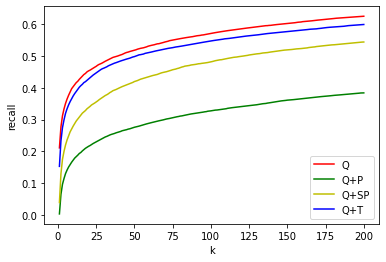

In [216]:
dpr_q_recalls_at_k = [s / len(samples) for s in dpr_recalls_at_k]
plt.plot(x[:200], dpr_q_recalls_at_k[:200], color='r', label="Q")
plt.plot(x[:200], dpr_qp_recalls_at_k[:200], color='g', label="Q+P")
plt.plot(x[:200], dpr_qsp_recalls_at_k[:200], color='y', label="Q+SP")
plt.plot(x[:200], dpr_qt_recalls_at_k[:200], color='b', label="Q+T")
plt.xlabel("k")
plt.ylabel("recall")
plt.legend(loc="best")
plt.show()

In [75]:
top_k = 10
bm25_hits, bm25_recalls = set(), set()
dpr_hits, dpr_recalls = set(), set()
for i, (bm25_ranks, dpr_ranks) in enumerate(zip(all_ranks, dpr_all_ranks)):
    if max(bm25_ranks.values()) <= top_k:
        bm25_hits.add(i)
    if min(bm25_ranks.values()) <= top_k:
        bm25_recalls.add(i)
    if max(dpr_ranks.values()) <= top_k:
        dpr_hits.add(i)
    if min(dpr_ranks.values()) <= top_k:
        dpr_recalls.add(i)

print(len(dpr_hits - bm25_hits), len(dpr_hits), len(dpr_hits & bm25_hits), len(bm25_hits), len(bm25_hits - dpr_hits))
print(len(dpr_recalls - bm25_recalls), len(dpr_recalls), len(dpr_recalls & bm25_recalls), len(bm25_recalls), len(bm25_recalls - dpr_recalls))

409 1050 641 2279 1638
518 4929 4411 6306 1895


## eval MDR on the HotpotQA dev set

## sparse vs dense

|      |                  | hits@1     | hits@2     | hits@5     | hits@10    | hits@20    | hits@50    |
| :--- | :--------------: | :--------: | :--------: | :--------: | :--------: | :--------: | :--------: |
| Hop1 | BM25(g\*(Q))     | 85\.71     | 90\.74     | 94\.79     | 96\.07     | 97\.30     | 98\.33     |
|      | BM25(g(Q))       | **75\.91** | **82\.90** | **88\.39** | **90\.99** | **93\.48** | **95\.44** |
|      | BM25(Q)          | 61\.57     | 71\.48     | 80\.34     | 85\.63     | 89\.83     | 93\.50     |
|      | MDR(Q)           | 75\.04     | 80\.58     | 84\.70     | 86\.99     | 88\.68     | 91\.15     |
| Hop2 | BM25(g\*(Q+SP1)) | 75\.85     | 80\.72     | 87\.32     | 90\.38     | 92\.82     | 94\.96     |
|      | BM25(g(Q+SP1))   | 62\.55     | 66\.79     | 71\.83     | 75\.45     | 78\.39     | 81\.49     |
|      | BM25(g(Q+5P)     | 59\.34     | 63\.28     | 68\.08     | 70\.65     | 72\.91     | 75\.11     |
|      | BM25(Q)          | 0\.00      | 11\.11     | 22\.73     | 30\.36     | 38\.16     | 48\.22     |
|      | MDR(Q+1P)        | **79\.84** | **85\.39** | **89\.31** | **91\.11** | **92\.75** | **94\.10** |
|      | MDR(Q+SP1)       | 91\.72     | 94\.62     | 96\.46     | 97\.31     | 97\.90     | 98\.46     |